# The Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df= pd.read_excel('cleandataiqr2911.xlsx', index_col=0)

In [3]:
identifier_columns = ['Country','ASBH02A']
demographic_info_columns = ['ASBH02A', 'ASBH02B', 'ASBH03A', 'ASBH04', 'ASBH15A', 'ASBH15B', 'ASBH16', 'ASBH17A', 'ASBH17B', 'ASBH18AA', 'ASBH18AB', 'ASBG01', 'ASBG03', 'ASDAGE','MINAGEARRIVAL' ]
positive_feelings_in_school = ['ASBG10A', 'ASBG10B','ASBG10C', 'ASBG10D', 'ASBG10E', 'ASBG10F']
negativeexperience_in_school_columns = ['ASBG11A', 'ASBG11B', 'ASBG11C', 'ASBG11D', 'ASBG11E', 'ASBG11F', 'ASBG11G', 'ASBG11H', 'ASBG11I', 'ASBG11J']
assessment_score_columns = ['ASRREA01', 'ASRREA02', 'ASRREA03', 'ASRREA04', 'ASRREA05', 'ASRLIT01', 'ASRLIT02', 'ASRLIT03', 'ASRLIT04', 'ASRLIT05', 'ASRINF01', 'ASRINF02', 'ASRINF03', 'ASRINF04', 'ASRINF05', 'ASRIIE01', 'ASRIIE02', 'ASRIIE03', 'ASRIIE04', 'ASRIIE05', 'ASRRSI01', 'ASRRSI02', 'ASRRSI03', 'ASRRSI04', 'ASRRSI05']
# averages = ['reading_avg', 'literary_purpose_avg', 'informational_purpose_avg','interpreting_process_avg', 'straightforward_process_avg','avgscore']

 1: Agree a lot; 2: Agree a little; 3: Disagree a little; 4: Disagree a lot\
 
ASBG10A	GEN\AGREE\BEING IN SCHOOL\
ASBG10B	GEN\AGREE\SAFE AT SCHOOL\
ASBG10C	GEN\AGREE\BELONG AT SCHOOL\
ASBG10D	GEN\AGREE\TEACHERS ARE FAIR\
ASBG10E	GEN\AGREE\PROUD TO GO TO SCHOOL\
ASBG10F	GEN\AGREE\FRIENDS AT SCHOOL

In [4]:
df['MINAGEARRIVAL'].value_counts(dropna=False)

NaN    38469
0.0     1108
3.0      852
6.0      480
8.0      249
Name: MINAGEARRIVAL, dtype: int64

In [5]:
df['MINAGEARRIVAL'] = df['MINAGEARRIVAL'].fillna(-1.0)

In [6]:
df['MINAGEARRIVAL'].value_counts(dropna=False)

-1.0    38469
 0.0     1108
 3.0      852
 6.0      480
 8.0      249
Name: MINAGEARRIVAL, dtype: int64

# Feelings in School

## Feelings Heat Map

In [7]:
df_feelings = df[identifier_columns+positive_feelings_in_school]

In [8]:
pivot_feelings = df_feelings.pivot_table(values=positive_feelings_in_school, index=identifier_columns, aggfunc='mean')

In [9]:
# Calculate the total average for each row
pivot_feelings['MeanTotal'] = pivot_feelings[['ASBG10A','ASBG10B','ASBG10C','ASBG10D','ASBG10E','ASBG10F']].mean(axis=1)

# Sort countries by the total average
country_averages = pivot_feelings.groupby('Country')['MeanTotal'].mean().sort_values(ascending=True).index.tolist()

### Create a custom sorter for ASBH02A
asbh02a_sorter = ['Yes', 'No']

In [10]:
# Get the current index as a DataFrame for sorting
index_feelings = pivot_feelings.index.to_frame()

In [11]:
# Rename the columns to avoid conflict
index_feelings = index_feelings.rename(columns={'Country': 'Country_', 'ASBH02A': 'ASBH02A_'})

# Sort the DataFrame first by Country using the sorted_countries and then by ASBH02A using the custom sorter
index_feelings['Country_'] = pd.Categorical(index_feelings['Country_'], categories=country_averages, ordered=True)
index_feelings['ASBH02A_'] = pd.Categorical(index_feelings['ASBH02A_'], categories=asbh02a_sorter, ordered=True)
index_feelings = index_feelings.sort_values(by=['Country_', 'ASBH02A_'])

# Reindex the pivot table using the sorted index
sorted_pivot_feelings = pivot_feelings.loc[index_feelings.index]

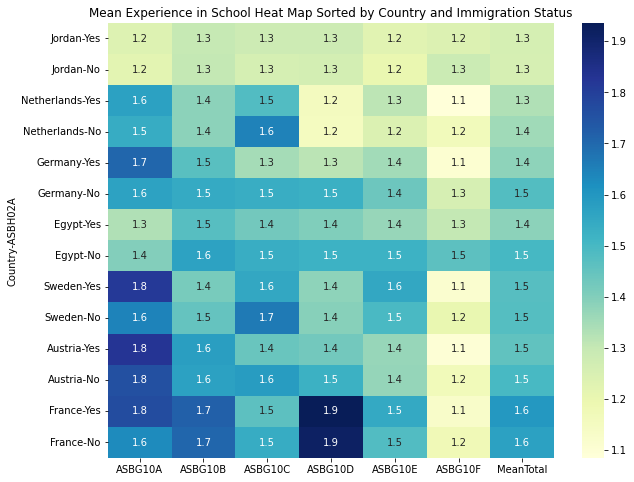

In [12]:
# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_pivot_feelings, annot=True, cmap='YlGnBu')
plt.title('Mean Experience in School Heat Map Sorted by Country and Immigration Status')
plt.show()

## Feelings Average Distribution

In [13]:
df['feelingsavg'] = df[positive_feelings_in_school].mean(axis=1)

In [14]:
df['feelingsavg_binned'] = pd.cut(df['feelingsavg'], bins=10)

In [15]:
# Create a contingency table
contingency_feelings = pd.crosstab(index = [df['ASBH02A'], df['Country']],columns=df['feelingsavg_binned'])

In [16]:
# Convert the contingency table to a format suitable for Plotly
contingency_feelings_reset = contingency_feelings.reset_index()
contingency_feelings_melted = contingency_feelings_reset.melt(id_vars=['ASBH02A','Country'], var_name='feelingsavg_binned', value_name='count')
# Convert Interval objects to strings
contingency_feelings_melted['feelingsavg_binned'] = contingency_feelings_melted['feelingsavg_binned'].astype(str)

In [17]:
df_yes = contingency_feelings_melted[contingency_feelings_melted['ASBH02A'] == 'Yes']

In [18]:
heatmap_yes = df_yes.pivot(index='Country',columns="feelingsavg_binned",values = "count")

In [19]:
heatmap_yes["total"]= heatmap_yes.sum(axis=1)
# Assuming your DataFrame is named df
# Copy the total column to a variable, we'll use it for division later
total_column_yes = heatmap_yes['total']

# Dividing all columns except the 'total' column by the 'total' column of that row
df_percentage_yes = heatmap_yes.div(total_column_yes, axis=0) * 100
df_percentage_yes = df_percentage_yes.drop("total", axis = 1)
# Convert the contingency table to a format suitable for Plotly
df_percentage_yes_reset = df_percentage_yes.reset_index()
df_percentage__yes_melted = df_percentage_yes_reset.melt(id_vars='Country', var_name='feelingsavg_binned', value_name='percentage')

In [20]:
# Convert Interval objects to strings
df_percentage__yes_melted['feelingsavg_binned'] = df_percentage__yes_melted['feelingsavg_binned'].astype(str)

In [21]:
# Convert feelingsavg_binned to categorical with the specified order
df_percentage__yes_melted['feelingsavg_binned'] = pd.Categorical(df_percentage__yes_melted['feelingsavg_binned'], 
                                       categories=[
                                           '(0.997, 1.3]','(1.3, 1.6]','(1.6, 1.9]','(1.9, 2.2]','(2.2, 2.5]','(2.5, 2.8]','(2.8, 3.1]','(3.1, 3.4]','(3.4, 3.7]','(3.7, 4.0]'], 
                                       ordered=True)

In [22]:
heatmap_percent_yes = df_percentage__yes_melted.pivot(index = "feelingsavg_binned", columns = "Country", values = "percentage")

In [23]:
df_no = contingency_feelings_melted[contingency_feelings_melted['ASBH02A'] == 'No']
df_no= df_no.drop('ASBH02A', axis=1)
heatmap_no = df_no.pivot(index='Country',columns="feelingsavg_binned",values = "count")

In [24]:
heatmap_no["total"] = heatmap_no.sum(axis=1)
# Assuming your DataFrame is named df
# Copy the total column to a variable, we'll use it for division later
total_column_no = heatmap_no['total']

# Dividing all columns except the 'total' column by the 'total' column of that row
df_percentage_no = heatmap_no.div(total_column_no, axis=0) * 100
df_percentage_no = df_percentage_no.drop("total", axis=1)
# Convert the contingency table to a format suitable for Plotly
df_percentage_no_reset = df_percentage_no.reset_index()
df_percentage_no_melted = df_percentage_no_reset.melt(id_vars='Country', var_name='feelingsavg_binned', value_name='percentage')


In [25]:
# Convert Interval objects to strings
df_percentage_no_melted['feelingsavg_binned'] = df_percentage_no_melted['feelingsavg_binned'].astype(str)

# Convert feelingsavg_binned to categorical with the specified order
# Convert feelingsavg_binned to categorical with the specified order
df_percentage_no_melted['feelingsavg_binned'] = pd.Categorical(df_percentage_no_melted['feelingsavg_binned'], 
                                       categories=[
                                           '(0.997, 1.3]','(1.3, 1.6]','(1.6, 1.9]','(1.9, 2.2]','(2.2, 2.5]','(2.5, 2.8]','(2.8, 3.1]','(3.1, 3.4]','(3.4, 3.7]','(3.7, 4.0]'], 
                                       ordered=True)

heatmap_percent_no = df_percentage_no_melted.pivot(index="feelingsavg_binned", columns="Country", values="percentage")


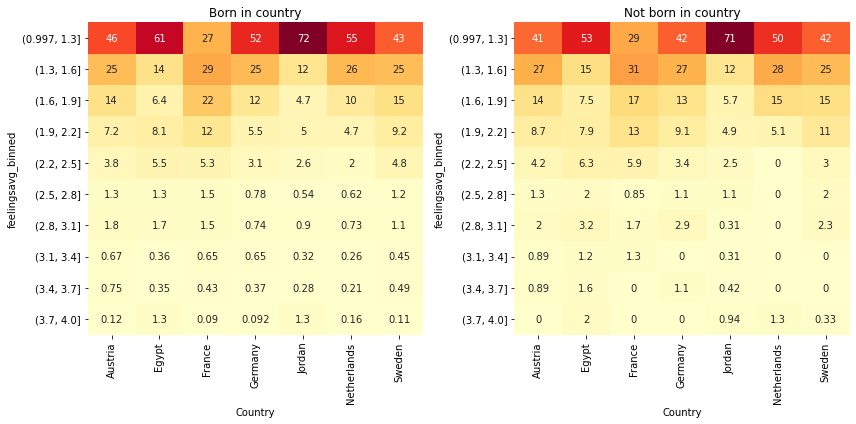

In [26]:
# Create a figure and set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot heatmaps
sns.heatmap(heatmap_percent_yes, ax=axes[0], cmap='YlOrRd', annot=True, cbar=False)
sns.heatmap(heatmap_percent_no, ax=axes[1], cmap='YlOrRd', annot= True, cbar=False)

# Set titles
axes[0].set_title('Born in country')
axes[1].set_title('Not born in country')

# Show the plot
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Country', ylabel='feelingsavg_binned'>

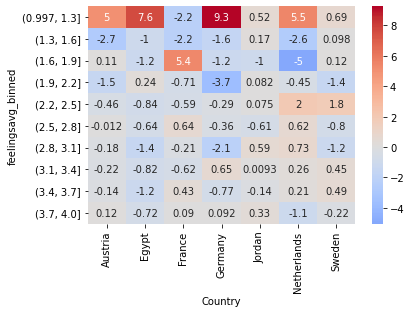

In [27]:
diff_data = heatmap_percent_yes - heatmap_percent_no

# Plot the difference heatmap
sns.heatmap(diff_data, cmap="coolwarm", annot = True, center=0)

## Minimum age of arrival

Now I want to see how age of arrival affects average score. I need to first clean the minagearrival column - adding 'NA' for those who were born in country

In [28]:
pivot_minage_feelings = df.pivot_table(values='feelingsavg', index=['Country'],columns=['MINAGEARRIVAL'],dropna = False)

In [29]:
pivot_minage_feelings

MINAGEARRIVAL,-1.0,0.0,3.0,6.0,8.0
Country,,,,,
Austria,1.458053,1.443902,1.528927,1.476923,1.559887
Egypt,1.402920,1.479006,1.418519,1.740196,1.615278
France,1.593398,1.602564,1.665459,1.462585,1.533333
Germany,1.384632,1.446809,1.465128,1.555238,1.511538
Iran,NaN,NaN,NaN,NaN,NaN
Jordan,1.270166,1.263266,1.284843,1.267003,1.382051
Netherlands,1.334791,1.358974,1.406250,1.362963,1.200000
Sweden,1.474186,1.499383,1.482201,1.402252,1.526126
Turkey,NaN,NaN,NaN,NaN,NaN


In [30]:
# Step 2: Calculate the mean score for each country
country_mean_scores = pivot_minage_feelings.groupby(level='Country').mean()

# If you want to sum the mean scores across all assessment columns (if there are multiple), you can do:
country_mean_scores['MeanTotal'] = country_mean_scores.mean(axis=1)

# Sort countries by total values
sorted_countries_means = country_mean_scores.sort_values(by='MeanTotal', ascending=False).index

# Get the current index as a DataFrame for sorting
index_df = pivot_minage_feelings.index.to_frame()

# Rename the columns to avoid conflict
index_df = index_df.rename(columns={'Country': 'Country_'})

# Sort the DataFrame first by Country using the sorted_countries and then by ASBH02A using the custom sorter
index_df['Country_'] = pd.Categorical(index_df['Country_'], categories=sorted_countries_means, ordered=True)
##index_df['ASBH02A_'] = pd.Categorical(index_df['ASBH02A_'], categories=asbh02a_sorter, ordered=True)
index_df = index_df.sort_values(by=['Country_'])

# Reindex the pivot table using the sorted index
sorted_pivot_df = pivot_minage_feelings.loc[index_df.index]

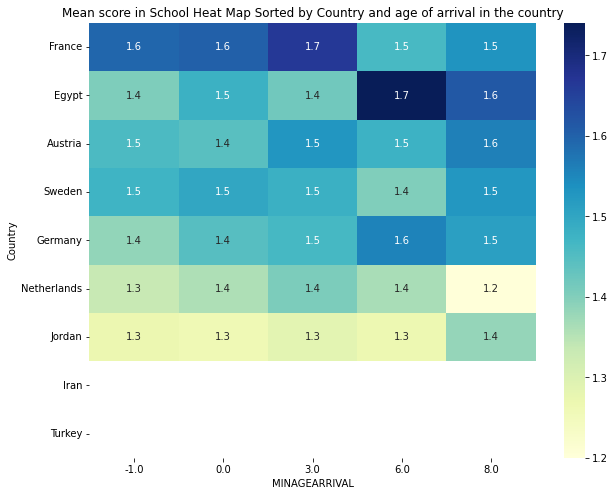

In [31]:
# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_pivot_df, annot=True, cmap='YlGnBu')
plt.title('Mean score in School Heat Map Sorted by Country and age of arrival in the country')
plt.show()

# Experience in School

## Experience in School Heatmap

In [32]:
df_experience = df[identifier_columns+negativeexperience_in_school_columns]

In [33]:
pivot_experience = df_experience.pivot_table(values=negativeexperience_in_school_columns, index=identifier_columns, aggfunc='mean')

In [34]:
pivot_experience

ASBG11A   ASBG11B   ASBG11C   ASBG11D   ASBG11E  \
Country     ASBH02A                                                     
Austria     No       2.726457  2.986517  2.866817  3.460137  3.269058   
            Yes      3.041048  3.184503  3.121587  3.604669  3.510338   
Egypt       No       2.904167  2.927660  3.142857  3.177966  3.167364   
            Yes      3.076520  3.042912  3.273051  3.308431  3.250813   
France      No       3.271186  3.374468  3.393162  3.512821  3.761702   
            Yes      3.376076  3.416213  3.461259  3.709567  3.752840   
Germany     No       2.947059  2.885542  3.082840  3.421687  3.430303   
            Yes      3.097504  3.055477  3.402086  3.721826  3.667313   
Jordan      No       3.383117  3.284483  3.385621  3.461787  3.491979   
            Yes      3.394960  3.334816  3.397000  3.504450  3.482476   
Netherlands No       3.000000  3.243590  3.012987  3.545455  3.551282   
            Yes      3.235884  3.219989  3.184771  3.598825  3.646432   
Sweden      No       2.929293  3.167235  3.217993  3.512195  3.262411   
            Yes      3.107102  3.390972  3.462949  3.689496  3.453879   

                      ASBG11F   ASBG11G   ASBG11H   ASBG11I   ASBG11J  
Country     ASBH02A                                                    
Austria     No       3.022422  3.357143  3.399103  3.659243  3.654709  
            Yes      3.166541  3.540146  3.624811  3.788297  3.718884  
Egypt       No       3.038136  3.173160  3.252137  3.301724  3.290598  
            Yes      3.185149  3.341105  3.369807  3.402553  3.340488  
France      No       3.282051  3.646809  3.862661  3.885106  3.719149  
            Yes      3.353102  3.691431  3.877760  3.922972  3.760055  
Germany     No       3.220930  3.497041  3.610778  3.700599  3.658683  
            Yes      3.210526  3.673095  3.764151  3.854900  3.739318  
Jordan      No       3.503767  3.598281  3.618844  3.655508  3.591684  
            Yes      3.532611  3.607752  3.636685  3.680639  3.619787  
Netherlands No       2.923077  3.346154  3.743590  3.805195  3.666667  
            Yes      3.026582  3.549072  3.669304  3.722809  3.776842  
Sweden      No       3.199324  3.614334  3.593857  3.775862  3.612457  
            Yes      3.347974  3.698328  3.723258  3.890923  3.738592

In [35]:
# Calculate the total average for each row
pivot_experience['MeanTotal'] = pivot_experience[['ASBG11A', 'ASBG11B', 'ASBG11C', 'ASBG11D', 'ASBG11E', 'ASBG11F', 'ASBG11G', 'ASBG11H', 'ASBG11I', 'ASBG11J']].mean(axis=1)

# Sort countries by the total average
country_averages = pivot_experience.groupby('Country')['MeanTotal'].mean().sort_values(ascending=False).index.tolist()

### Create a custom sorter for ASBH02A
asbh02a_sorter = ['Yes', 'No']

In [36]:
# Get the current index as a DataFrame for sorting
index_experience = pivot_experience.index.to_frame()

In [37]:
# Rename the columns to avoid conflict
index_experience = index_experience.rename(columns={'Country': 'Country_', 'ASBH02A': 'ASBH02A_'})

# Sort the DataFrame first by Country using the sorted_countries and then by ASBH02A using the custom sorter
index_experience['Country_'] = pd.Categorical(index_experience['Country_'], categories=country_averages, ordered=True)
index_experience['ASBH02A_'] = pd.Categorical(index_experience['ASBH02A_'], categories=asbh02a_sorter, ordered=True)
index_experience = index_experience.sort_values(by=['Country_', 'ASBH02A_'])

# Reindex the pivot table using the sorted index
sorted_pivot_df = pivot_experience.loc[index_experience.index]

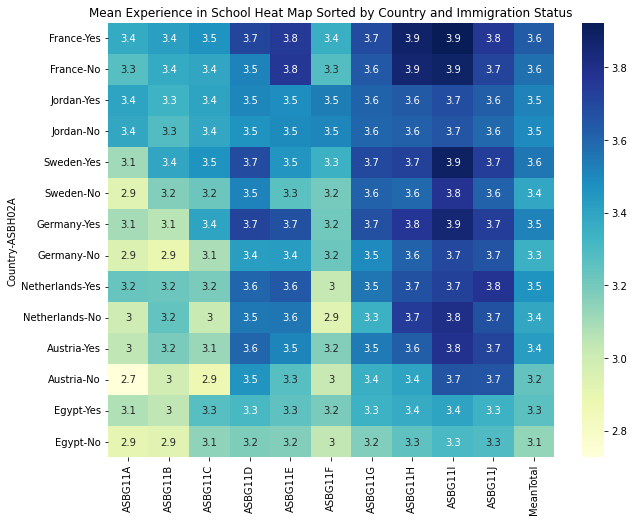

In [38]:
# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_pivot_df, annot=True, cmap='YlGnBu')
plt.title('Mean Experience in School Heat Map Sorted by Country and Immigration Status')
plt.show()

 1: At least once a week; 2: Once or twice a month; 3: A few times a year; 4: Never
 
ASBG11A	GEN\HOW OFTEN\MADE FUN OF\
ASBG11B	GEN\HOW OFTEN\LEFT OUT OF GAMES\
ASBG11C	GEN\HOW OFTEN\SPREADING LIES ABOUT ME\
ASBG11D	GEN\HOW OFTEN\STEALING STH FROM ME\
ASBG11E	GEN\HOW OFTEN\DAMAGED STH OF MINE\
ASBG11F	GEN\HOW OFTEN\HIT OR HURT ME\
ASBG11G	GEN\HOW OFTEN\MADE ME DO\
ASBG11H	GEN\HOW OFTEN\NASTY OF HURTFUL MESSAGES\
ASBG11I	GEN\HOW OFTEN\NASTY OF HURTFUL INFO\
ASBG11J	GEN\HOW OFTEN\THREATENED ME\

darker colours are better

## Experience Average Distribution

In [39]:
df['experienceavg'] = df[negativeexperience_in_school_columns].mean(axis=1)

In [40]:
df['experienceavg_binned'] = pd.cut(df['experienceavg'], bins=10)

In [41]:
# Create a contingency table
contingency_experience = pd.crosstab(index = [df['ASBH02A'], df['Country']],columns=df['experienceavg_binned'])

In [97]:
# Convert the contingency table to a format suitable for plotting
contingency_experience_melted = contingency_experience.reset_index().melt(id_vars=['ASBH02A','Country'], var_name='experienceavg_binned', value_name='count')
# Convert Interval objects to strings
contingency_experience_melted['experienceavg_binned'] = contingency_experience_melted['experienceavg_binned'].astype(str)

### Separated functions

In [98]:
def filter_and_prepare_data(data, filter_column, filter_value, drop_column=None):
    """
    Filters the data based on a column value and optionally drops a column.
    
    Parameters:
    - data: pd.DataFrame, the input data.
    - filter_column: str, the column to filter on.
    - filter_value: str, the value to filter by.
    - drop_column: str, optional, a column to drop after filtering.
    
    Returns:
    - pd.DataFrame, the filtered and optionally cleaned data.
    """
    filtered_data = data[data[filter_column] == filter_value]
    if drop_column and drop_column in filtered_data.columns:
        filtered_data = filtered_data.drop(drop_column, axis=1)
    return filtered_data

In [99]:
def create_pivot_table(data, index_col, column_col, value_col):
    """
    Creates a pivot table from the filtered data.
    
    Parameters:
    - data: pd.DataFrame, the input data.
    - index_col: str, column for the pivot index.
    - column_col: str, column for the pivot columns.
    - value_col: str, column for the pivot values.
    
    Returns:
    - pd.DataFrame, the pivot table.
    """
    return data.pivot(index=index_col, columns=column_col, values=value_col)

In [100]:
def normalize_to_percentages(pivot_table):
    """
    Normalizes pivot table values to percentages.
    
    Parameters:
    - pivot_table: pd.DataFrame, the input pivot table with a "total" column.
    
    Returns:
    - pd.DataFrame, the pivot table normalized to percentages.
    """
    pivot_table["total"] = pivot_table.sum(axis=1)
    total_column = pivot_table["total"]
    normalized_table = pivot_table.div(total_column, axis=0) * 100
    return normalized_table.drop("total", axis=1)

In [101]:
def melt_and_format_data(pivot_table, id_col, melt_col, value_name):
    """
    Converts a pivot table to a melted format and formats categorical bins.
    
    Parameters:
    - pivot_table: pd.DataFrame, the input pivot table.
    - id_col: str, column to use as the identifier in the melted table.
    - melt_col: str, the column to melt (e.g., a column from the pivot table).
    - value_name: str, name for the values in the melted table.
    - bin_order: list of str, ordered categories for the bins.
    
    Returns:
    - pd.DataFrame, the melted and formatted data.
    """
    melted = pivot_table.reset_index().melt(id_vars=id_col, var_name=melt_col, value_name=value_name)
    return melted


In [102]:
def generate_heatmap(data, filter_column, filter_value, index_col, column_col, value_col):
    """
    Generates a heatmap from the data based on filtering, pivoting, and normalizing steps.
    
    Parameters:
    - data: pd.DataFrame, the input data.
    - filter_column: str, column to filter on.
    - filter_value: str, value to filter by.
    - index_col: str, column for the pivot index.
    - column_col: str, column for the pivot columns.
    - value_col: str, column for the pivot values.
    - bin_order: list of str, ordered categories for the bins.
    
    Returns:
    - pd.DataFrame, the final heatmap as a pivot table.
    """
    filtered_data = filter_and_prepare_data(data, filter_column, filter_value, drop_column=filter_column)
    pivot_table = create_pivot_table(filtered_data, index_col=index_col, column_col=column_col, value_col=value_col)
    normalized_table = normalize_to_percentages(pivot_table)
    melted_data = melt_and_format_data(
        normalized_table, id_col=index_col, melt_col=column_col, value_name="percentage"
    )
    heatmap = melted_data.pivot(index=column_col, columns=index_col, values="percentage")
    return heatmap


In [103]:
heatmap_experience_native_born = generate_heatmap(
    data=contingency_experience_melted,
    filter_column='ASBH02A',
    filter_value='Yes',
    index_col='Country',
    column_col='experienceavg_binned',
    value_col='count',
)

heatmap_experience_foreign_born = generate_heatmap(
    data=contingency_experience_melted,
    filter_column='ASBH02A',
    filter_value='No',
    index_col='Country',
    column_col='experienceavg_binned',
    value_col='count',
)

#### Plotting

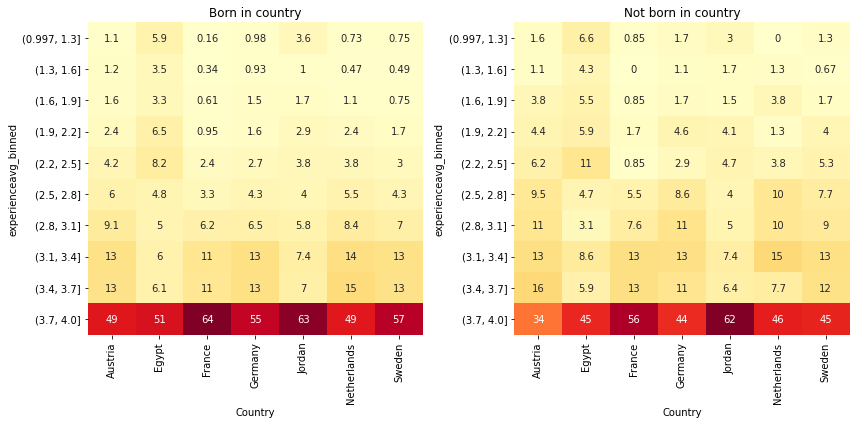

In [104]:
# Create a figure and set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot heatmaps
sns.heatmap(heatmap_experience_native_born, ax=axes[0], cmap='YlOrRd', annot=True, cbar=False)
sns.heatmap(heatmap_experience_foreign_born, ax=axes[1], cmap='YlOrRd', annot= True, cbar=False)

# Set titles
axes[0].set_title('Born in country')
axes[1].set_title('Not born in country')

# Show the plot
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Country', ylabel='experienceavg_binned'>

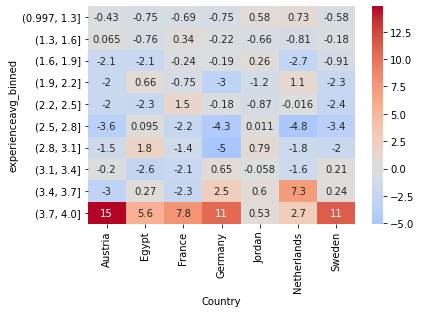

In [105]:
diff_data = heatmap_experience_native_born - heatmap_experience_foreign_born

# Plot the difference heatmap
sns.heatmap(diff_data, cmap="coolwarm", annot = True, center=0)

## Minimum age of arrival

Now I want to see how age of arrival affects average score. I need to first clean the minagearrival column - adding 'NA' for those who were born in country

In [106]:
pivot_minage_experience = df.pivot_table(values='experienceavg', index=['Country'],columns=['MINAGEARRIVAL'],dropna = False)

In [107]:
pivot_minage_experience

MINAGEARRIVAL,-1.0,0.0,3.0,6.0,8.0
Country,,,,,
Austria,3.427577,3.279088,3.215143,3.300580,3.102980
Egypt,3.195749,3.125283,3.009965,3.203571,3.070602
France,3.629238,3.617415,3.549436,3.528798,3.619111
Germany,3.512689,3.402297,3.295580,3.326879,3.461111
Iran,NaN,NaN,NaN,NaN,NaN
Jordan,3.492736,3.476802,3.440322,3.442966,3.376955
Netherlands,3.460112,3.362500,3.343750,3.387654,3.590000
Sweden,3.544466,3.458985,3.395793,3.317535,3.232733
Turkey,NaN,NaN,NaN,NaN,NaN


In [114]:
mean_scores_test = (
        pivot_minage_experience.groupby(level='Country').mean()
        .assign(MeanTotal=lambda df: df.mean(axis=1))
        .sort_values(by='MeanTotal', ascending=False)
    )

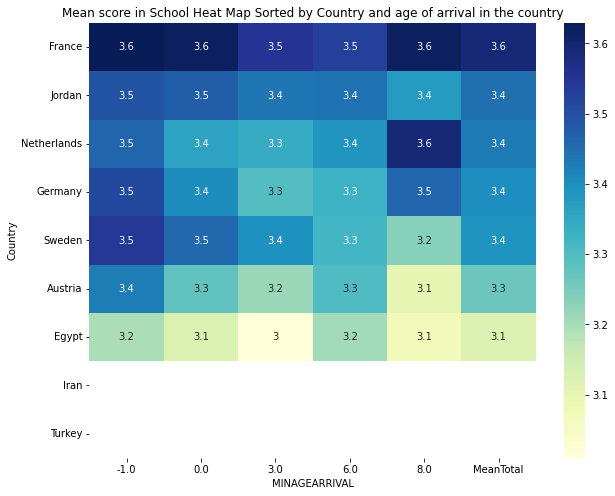

In [115]:
# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(mean_scores_test, annot=True, cmap='YlGnBu')
plt.title('Mean score in School Heat Map Sorted by Country and age of arrival in the country')
plt.show()

In [108]:
def process_pivot_table(pivot_table, group_by_column):
    """
    Processes a pivot table by calculating mean scores for each group, 
    sorting by the mean total, and reindexing the table accordingly.

    Parameters:
    pivot_table (pd.DataFrame): The pivot table with a multi-index.
    group_by_column (str): The column name in the index to group by.

    Returns:
    pd.DataFrame: The sorted pivot table.
    """
    # Calculate mean scores for the specified group and add a total mean column
    mean_scores = (
        pivot_table.groupby(level=group_by_column).mean()
        .assign(MeanTotal=lambda df: df.mean(axis=1))
        .sort_values(by='MeanTotal', ascending=False)
    )
    

    # Extract and prepare the index DataFrame
    index_df = pivot_table.index.to_frame()

    # Rename all index columns to avoid conflicts
    index_df = index_df.rename(columns={col: f"{col}_" for col in index_df.columns})

    # Dynamically handle sorting for the specified group column
    group_by_column_renamed = f"{group_by_column}_"
    index_df[group_by_column_renamed] = pd.Categorical(
        index_df[group_by_column_renamed], categories=mean_scores.index, ordered=True
    )

    # Sort index DataFrame
    #sorted_index = index_df.sort_values(by=[group_by_column_renamed]).index

    # Reindex and return the sorted pivot table
    return pivot_table.loc[sorted_index]


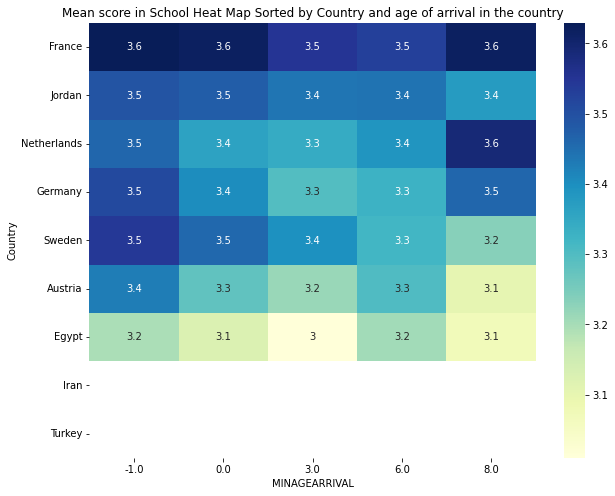

In [113]:
# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_minage_experience, annot=True, cmap='YlGnBu')
plt.title('Mean score in School Heat Map Sorted by Country and age of arrival in the country')
plt.show()

Next steps - comparisons with bench marks - through line? 
Should compare reading scores with the benchmark and can also compare with previous years.
If I get data from different dates maybe I can practice the time/date stuff. change asbh02a to immigrant/ non - immigrant